In [352]:
import numpy as np
import math
import random
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import linalg as LA
from pprint import pprint
import pandas as pd

In [353]:
examples = np.array([[[5, -12], [0, 0], [5, 11], [-7, 5], [-6, -6]], [[-9, -7], [3, -6], [4, 0], [2, 6], [-3, 2]],[[-9, -6], [-1, -2], [0, -13], [4, -10], [17, -9], [0, 0], [5, 2], [8, 17], [1, 9], [-3, 10], [-14, 9], [-12, 0]], [[0, 0], [1, 2], [-1, 3], [-5, 0], [-3, -4], [-1, -2], [-5, 6], [5, 6], [6, 0]], [[0, 0], [2, 1], [3, 3], [3, 5], [2, 7], [0, 8], [-2, 7], [-3, 5], [-3, 3], [-2, 1], [0, 0], [2, -1], [3, -3], [3, -5], [2, -7], [0, -8], [-2, -7], [-3, -5], [-3, -3], [-2, -1]], [[-9.486832980505138, -3.1622776601683795], [-9.284766908852594, -3.713906763541037], [-8.94427190999916, -4.47213595499958], [-8.741572761215377, -4.856429311786321], [-8.320502943378438, -5.547001962252292], [-7.0710678118654755, -7.0710678118654755], [-5.547001962252292, -8.320502943378438], [-4.9613893835683385, -8.682431421244592], [-4.47213595499958, -8.94427190999916], [-3.713906763541037, -9.284766908852594], [-3.1622776601683795, -9.486832980505138], [0.0, -10.0], [1.9611613513818404, -9.805806756909202], [4.47213595499958, -8.94427190999916], [5.812381937190965, -8.13733471206735], [6.643638388299198, -7.474093186836597], [7.071067811865475, -7.071067811865475], [8.0, -6.0], [8.320502943378436, -5.54700196225229], [9.70142500145332, -2.42535625036333], [9.76187060183953, -2.1693045781865616], [9.922778767136677, -1.2403473458920846], [9.938837346736188, -1.1043152607484654], [9.938837346736188, 1.1043152607484654], [9.922778767136677, 1.2403473458920846], [9.899494936611665, 1.414213562373095], [9.76187060183953, 2.1693045781865616], [8.57492925712544, 5.144957554275265], [8.320502943378436, 5.54700196225229], [8.192319205190405, 5.734623443633283], [8.0, 6.0], [5.734623443633283, 8.192319205190405], [4.47213595499958, 8.94427190999916], [3.713906763541037, 9.284766908852594], [3.1622776601683795, 9.486832980505138], [0.0, 10.0], [-0.9950371902099892, 9.950371902099892], [-2.42535625036333, 9.70142500145332], [-2.873478855663454, 9.578262852211513], [-3.1622776601683795, 9.486832980505138], [-3.939192985791676, 9.191450300180579], [-4.47213595499958, 8.94427190999916], [-5.547001962252292, 8.320502943378438], [-6.0, 8.0], [-6.139406135149205, 7.893522173763263], [-6.246950475544243, 7.808688094430304], [-7.071067811865475, 7.071067811865475], [-7.5925660236529655, 6.5079137345596845], [-8.13733471206735, 5.812381937190965], [-9.284766908852594, 3.713906763541037], [-9.363291775690445, 3.511234415883917], [-9.486832980505138, 3.1622776601683795], [-9.950371902099892, 0.9950371902099892], [-10.0, 0.0]]])

curvature_definition = 'D'
_ = np.seterr(divide='ignore', invalid='ignore')

In [354]:
def right_turn(vector):
    return np.array([-vector[1], vector[0]])

def circumcenter(triangle):
    """
    given a triangle as a numpy matrix of shape (3,2), returns its circumcenter
    """
    d = 2 * np.sum(np.cross(triangle[:, 0], triangle[:, 1]))
    norms = np.array([np.dot(triangle[i], triangle[i]) for i in range(3)])
    U = [np.sum(np.cross(triangle[:, i], norms)) for i in range(2)]
    if d == 0:
        return None
    return right_turn(U) / d

def dist(a, b):
    return math.hypot(b[0] - a[0], b[1] - a[1])

def which_turn(a, b, c):
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    ab = b - a
    bc = c - b
    res = +ab[0]*bc[1]-ab[1]*bc[0]
    if res >= 0:
        return 1.
    else:
        return -1.


In [355]:
def get_circles_centers(verts):
    ans = []
    for i in range(len(verts)):
        center = circumcenter(
            np.array(
                [
                    verts[i-1], verts[i], verts[(i + 1) % len(verts)]
                ]
            )
        )
        if center is None:
            ans.append([np.inf, np.inf])
        else:
            ans.append(center)
    return np.array(ans)


# returns the angle of rotation of the curve at each vertex, angle in [-pi, pi]
def get_angles(verts_):
    # add the last vertex to the front and the first to the back
    verts = np.concatenate(([verts_[-1]], verts_, [verts_[0]]))
    ab = verts[1:-1] - verts[:-2]
    bc = verts[2:] - verts[1:-1]
    cosine_angle = (ab * bc).sum(axis=1) / \
                    np.linalg.norm(ab, axis=1) / \
                    np.linalg.norm(bc, axis=1)
    angle = np.arccos(cosine_angle)
    angle = np.nan_to_num(angle)
    ans = []
    for i in range(len(verts_)):
        a, b, c = verts_[i-1], verts_[i], verts_[(i + 1) % len(verts_)] 
        ans.append(angle[i] * which_turn(a, b, c))
    return np.array(ans)
        
# returns an np.array of numbers k at all vertices 
# (k is curvature at corresponding vertex)
def get_curvatures(verts):
    angles = get_angles(verts)
    if curvature_definition == 'A':
        #print('here A\n')
        return angles
    elif curvature_definition == 'B':
        return 2 * np.sin(angles / 2.)
    elif curvature_definition == 'C':
        return 2 * np.tan(angles / 2.)
    elif curvature_definition == 'D':
        #print('here D\n')
        circles_centers = get_circles_centers(verts)
        R = np.sqrt(
                np.sum(
                        (verts - circles_centers) ** 2, 
                        axis=-1
                )
        )
        return np.nan_to_num(1. / R)
    
def is_round(verts):
    center = circumcenter(np.array([verts[0], verts[1], verts[2]]))
    #print(center)
    true_dist = dist(verts[1], center)
    max_diff = 0
    for i in range(len(verts)):
        max_diff = max(max_diff, dist(verts[i], center) - true_dist)
    return max_diff < 0.01
        

# returns array of all normal vectors
def get_normals(verts):
    if curvature_definition == 'D':
        circles_centers = get_circles_centers(verts)
        return (circles_centers - verts) / \
                LA.norm(circles_centers - verts, axis=1, keepdims=True)
    else: 
        # if curvature_definition is 'A' or 'B' or 'C'
        # find bisector 
        verts = np.concatenate(([verts[-1]], verts, [verts[0]]))
        ab = verts[:-2] - verts[1:-1]
        bc = verts[2:] - verts[1:-1]

        bisectors = ab * np.linalg.norm(bc, axis=1, keepdims=True) + \
                    bc * np.linalg.norm(ab, axis=1, keepdims=True)
        return bisectors / np.linalg.norm(bisectors, axis=1, keepdims=True)
    
# returns an np.array of vectors kN at all vertices
def get_flow(verts):
    curvatures = np.nan_to_num(get_curvatures(verts))
    normals = np.nan_to_num(get_normals(verts))
    return normals * np.absolute(curvatures[:, None])
        
# replaces curve with (curve + step * flow) number_of_steps times
def get_transformation(verts, times=1, number_of_steps=10**3):
    step = 1. / number_of_steps
    ans = verts
    flow = get_flow(ans)
    for i in range(number_of_steps):    
        ans = ans + step * flow
    if times == 1:
        return ans
    else :
        return get_transformation(ans, times-1)

# returns sum of all curvatures (k) of verts 
def get_total_curvature(verts):
    return sum(get_curvatures(verts))

# returns the center of mass of the curve
def get_mass_center(verts):
    sum_weight = 0.
    sum_centers = np.array([0, 0])
    for i in range(len(verts)):
        a, b = np.array(verts[i-1]), np.array(verts[i])
        center_ab = a + b / 2.
        weight = np.linalg.norm(b-a)
        sum_weight += weight
        sum_centers = sum_centers + center_ab * weight
    return sum_centers / sum_weight

In [356]:
# draw vector (arrow) on the given plot with given parameters
def draw_vector(from_, to_, plt, color='black', width=0.001, 
                headwidth=10, scale=1, mult=1, headlength=10):
    plt.quiver(from_[0], from_[1], mult*(to_[0]-from_[0]), mult*(to_[1]-from_[1]), 
               angles='xy', scale_units='xy', scale=scale, color=color,
               width=width, headwidth=headwidth, headlength=headlength)

# connect all given vertices by drawing arrows
def draw_polygon(verts, plt):
    for i in range(1, len(verts)):
        draw_vector(verts[i-1], verts[i], plt)
    draw_vector(verts[-1], verts[0], plt)
        
# put dots on given plot at the points where the centers 
# of the circles are located
def draw_circles_centers(verts, ax):
    circles_centers = get_circles_centers(verts)
    for center in circles_centers:
        if center is not None:
            ax.scatter(*center, s=10, color='red')

# draw circles with centres in circles_centers and with a
# radius equal to the distance from the center to the the 
# corresponding vertex of the polygon
def draw_circles(verts, ax, step=1):
    circles_centers = get_circles_centers(verts)
    for i in range(0, len(verts), step):
        center = circles_centers[i]
        if center is not None:
            circle = plt.Circle(center, radius=dist(center, verts[i]),
                                color='red', fill=False, 
                                linewidth=0.9, alpha=0.6)
            ax.add_artist(circle)
            
#draws a vector of length 1 from the vertex of the polygon to the 
#center of the circle
def draw_normal_vertors(verts, ax):
    circles_centers = get_circles_centers(verts)
    for i in range(len(verts)):
        draw_vector(verts[i], circles_centers[i], ax, 
                    color='mediumblue', width=0.002, headwidth=4, 
                    headlength=4, 
                    scale=dist(verts[i], circles_centers[i])
                    )

def draw_kN(verts, ax):
    flow = get_flow(verts)
    for i in range(len(verts)):
        draw_vector(verts[i], verts[i] + flow[i], ax)

### Нарисуем замкнутую кривую 

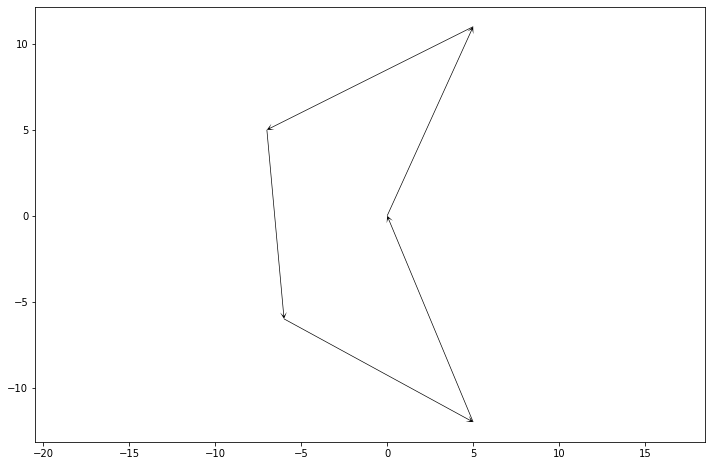

In [357]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1,1,1)
ax.axis('equal')
verts = np.array(examples[0])

draw_polygon(verts, ax)

### Вычислим и отобразим центры соответствующих окружностей для каждой точки

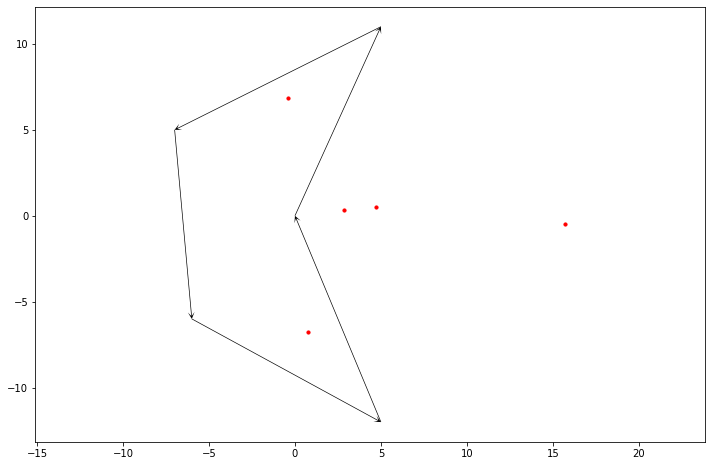

In [358]:
draw_circles_centers(verts, ax)
fig

### Для некоторых вершин построим эти окружности 

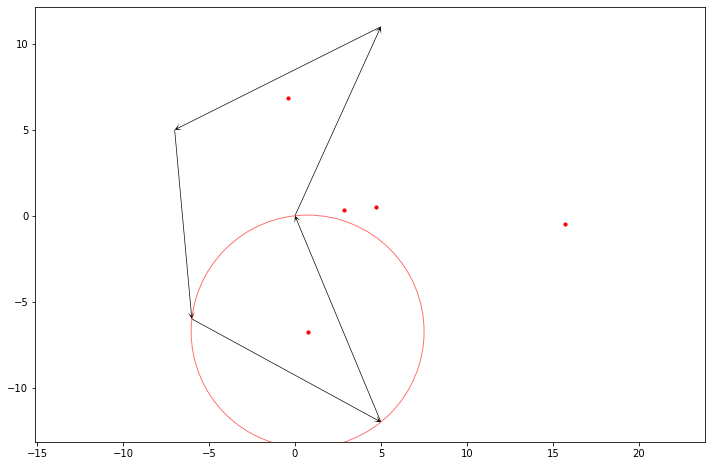

In [359]:
draw_circles(verts, ax, step=5)
fig

### Проведем из каждой точки кривой векторы единичной длины по направлению к центру соответствующей окружности (т.е. по радиусу)

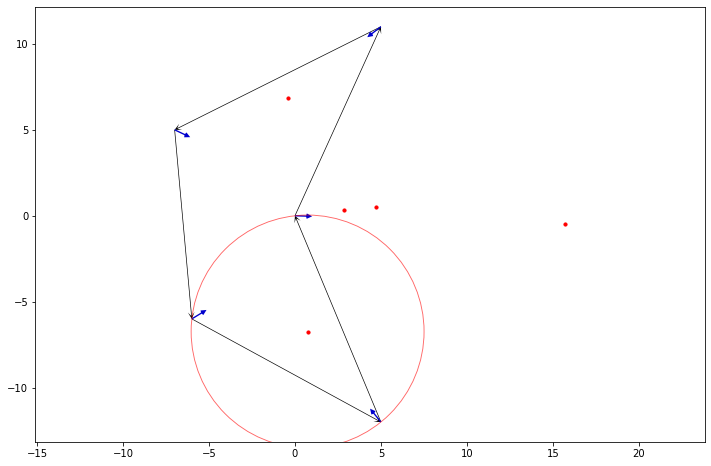

In [360]:
draw_normal_vertors(verts, ax)
fig

### Вычислим поток, вычислим преобразование нашей кривой и изобразим рядом исходную и полученную после преобразования кривые

(-7.6, 5.6)

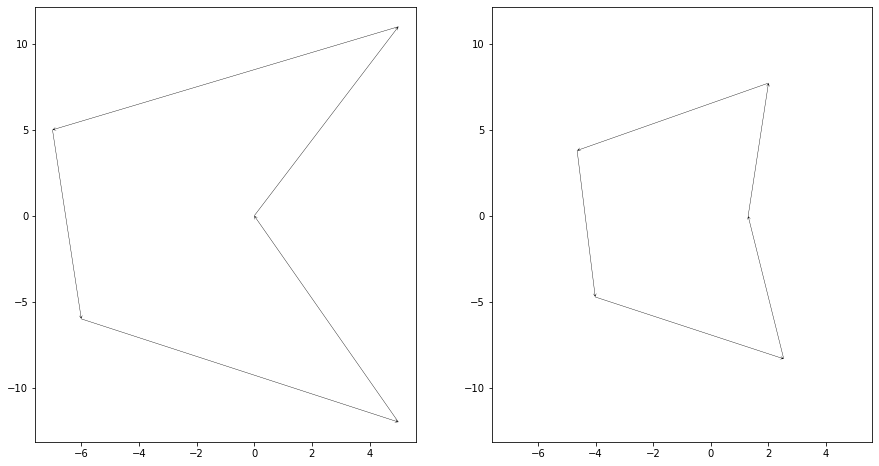

In [361]:
transformed_verts = get_transformation(verts, times=25)

ax1.axis('equal')
ax2.axis('equal')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))

draw_polygon(verts, ax1)
draw_polygon(transformed_verts, ax2)

ax2.set_ylim(ax1.get_ylim())
ax2.set_xlim(ax1.get_xlim())

### Теперь будем считать кривизну равной углу поворота кривой, т.е. $k_i^A = \theta_i $
### Для той же кривой так же выполним преобразование. Векторы нормали в этом случае будем направлять по биссектрисе. Отобразим на рисунке векторы kN, то есть единичные нормальные векторы, умноженные на кривизну. Видно, что чем больше угол поворота, тем длиннее соответствующий вектор из вершины

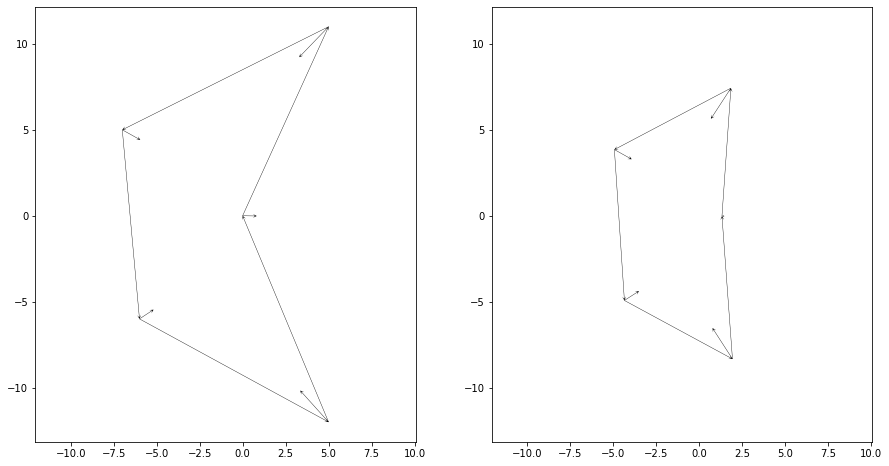

In [362]:
curvature_definition = 'A'

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))
ax1.axis('equal')
ax2.axis('equal')

transformed_verts = get_transformation(verts, times=2)

draw_polygon(verts, ax1)
draw_polygon(transformed_verts, ax2)

draw_kN(verts, ax1)
draw_kN(transformed_verts, ax2)

ax2.set_ylim(ax1.get_ylim())
ax2.set_xlim(ax1.get_xlim())
plt.show()

### Аналогично для кривизны $k_i^B = 2sin\frac{\theta_i}{2}$

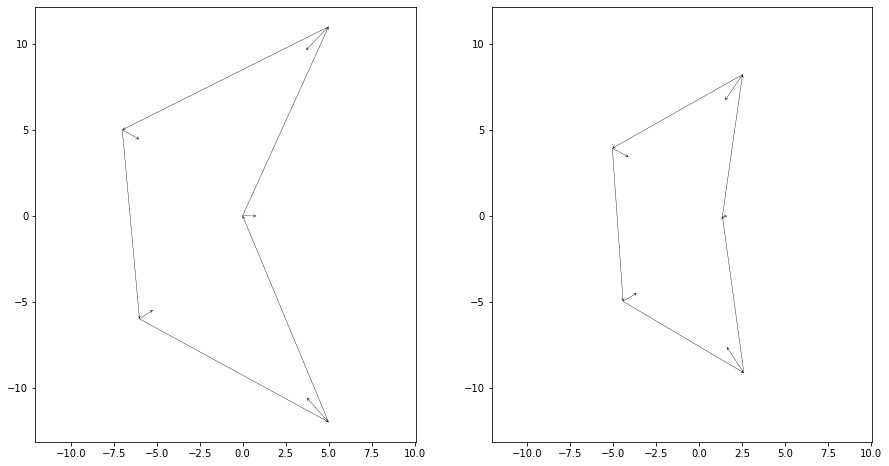

In [363]:
curvature_definition = 'B'

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))
ax1.axis('equal')
ax2.axis('equal')

transformed_verts = get_transformation(verts, times=2)

draw_polygon(verts, ax1)
draw_polygon(transformed_verts, ax2)

draw_kN(verts, ax1)
draw_kN(transformed_verts, ax2)

ax2.set_ylim(ax1.get_ylim())
ax2.set_xlim(ax1.get_xlim())
plt.show()

### Аналогично для кривизны $k_i^C = 2tg\frac{\theta_i}{2}$

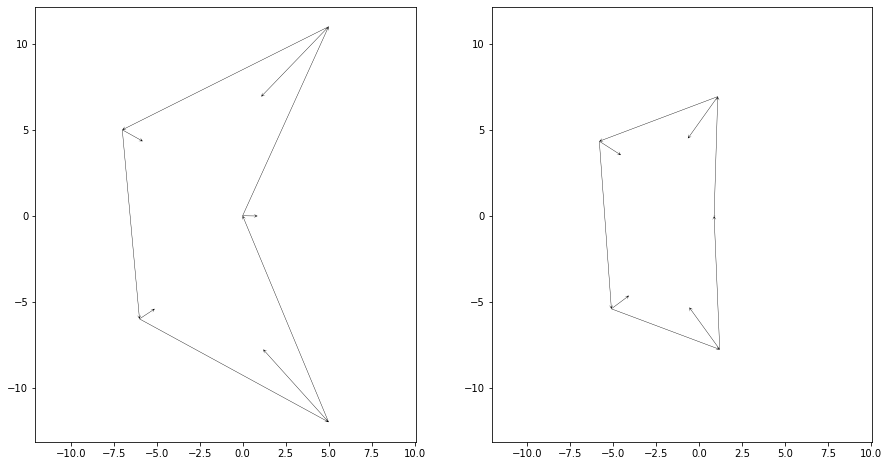

In [364]:
curvature_definition = 'C'

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))
ax1.axis('equal')
ax2.axis('equal')

transformed_verts = get_transformation(verts, times=1)

draw_polygon(verts, ax1)
draw_polygon(transformed_verts, ax2)

draw_kN(verts, ax1)
draw_kN(transformed_verts, ax2)

ax2.set_ylim(ax1.get_ylim())
ax2.set_xlim(ax1.get_xlim())
plt.show()

### Рассмотрим теперь несколько других кривых:

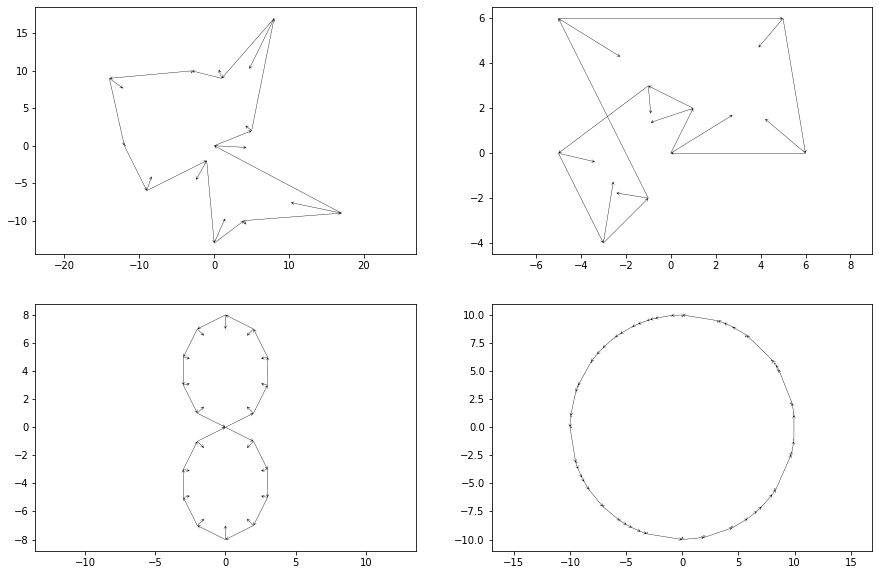

In [365]:

axs = [0] * 4
xlims = []
ylims = []
fig, ((axs[0], axs[1]), (axs[2], axs[3])) = plt.subplots(2, 2, figsize=(15,10))
for i in range(2, 6):
    axs[i-2].axis('equal')
    draw_polygon(examples[i], axs[i-2])
    draw_kN(examples[i], axs[i-2])
    ylims.append(np.array(axs[i-2].get_ylim())*1.25)
    xlims.append(np.array(axs[i-2].get_xlim())*1.25)


### Преобразуем их для наглядности, например, способом А

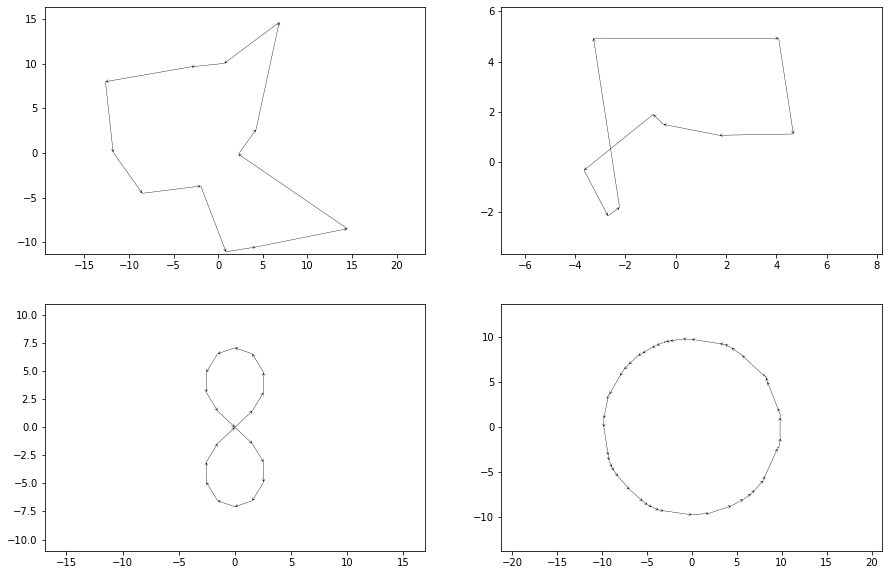

In [366]:
curvature_definition = 'A'
axs = [0] * 4
fig, ((axs[0], axs[1]), (axs[2], axs[3])) = plt.subplots(2, 2, figsize=(15,10))
for i in range(2, 6):
    axs[i-2].axis('equal')
    axs[i-2].set_xlim(xlims[i-2])
    axs[i-2].set_ylim(ylims[i-2])
    verts = examples[i]
    draw_polygon(get_transformation(verts), axs[i-2])

### Теперь поймем про каждый способ вычисления кривизны, какие свойства кривой он сохрняет
### Занесем результаты в таблицу, где:
### sum curv — средняя разница между суммарной кривизной у исходной кривой и у преобразованной
### mass center — среднее расстояние между исходным центром масс и после преобразования
### roundness — 1, если сохранилась "округлость", 0 иначе

In [367]:
possible_curvature_definitions = ['A', 'B', 'C', 'D']
df = pd.DataFrame(columns=['sum curv', 'mass center', 'roundness'], index=possible_curvature_definitions)

# iterate over all possible curvature definitions
for ind, definition in enumerate(possible_curvature_definitions):
    curvature_definition = definition
    
    sum_diff_center = 0
    sum_diff_curvature = 0
    save_is_round = 1
    
    # iterate over all possible curves
    for verts in examples:
        if definition == 'D':
            # in this case we need more iterations of transformation
            transformed_verts = get_transformation(verts, times=6)
        else:
            transformed_verts = get_transformation(verts, times=1)

        # find distance between mass center of original vertices and transformed
        diff_center = abs(np.linalg.norm(get_mass_center(verts) - get_mass_center(transformed_verts)))
        sum_diff_center += diff_center

        # find difference between total curvature of original vertices and transformed
        diff_curvature = abs(get_total_curvature(verts) - get_total_curvature(transformed_verts))
        sum_diff_curvature += diff_curvature

        # find out if original vertices lie on the the circle
        is_round_verts = is_round(verts)
        # find out if transformed vertices lie on the the circle
        is_round_trans = is_round(transformed_verts)
        # check if results are equal
        save_is_round *= (is_round_verts == is_round_trans)
    
    # write the data to the table
    df.iloc[ind][0] = "%.3f" % (sum_diff_curvature / len(examples))
    df.iloc[ind][1] = "%.3f" % (sum_diff_center / len(examples))
    df.iloc[ind][2] = save_is_round
df

,sum curv,mass center,roundness
A,0.000,0.313,0
B,0.124,0.182,0
C,4.339,1.196,0
D,1.150,0.343,1


# Итоги
### Мы видим, что способ А точно сохраняет суммарную кривизну. Более того, мы знаем, что в данном способе суммарная кривизна кратна $2\pi$. 
### Мы видим, что способ D точно сохраняет "округлость"
### Так же можно заметить, что способ B лучше остальных сохраняет центр масс, но все же центр масс во всех способах смещается достаточно ощутимо
### Способ C кажется наименее удачным, если опираться на полученные данные

### Таким образом, способ вычисления кризны у дискретной кривой нужно выбирать в соответствии с нашими задачами, учитывая то, какое из свойств мы бы хотели сохранить после сглаживания